<a href="https://colab.research.google.com/github/LuFernandez/PASA/blob/master/TP2/informe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Filtrado óptimo

Procesamiento Adaptativo de Señales Aleatorias

© 2019 Parra, Rocío

© 2019 Fernandez, Lucero Guadalupe

In [0]:
from IPython.display import clear_output
from scipy.io.wavfile import read
import numpy as np
import scipy
import IPython.display as ipd
import matplotlib.pyplot as plt
import wave, struct, math, random
from IPython.display import Audio
from scipy import signal as sgn
from scipy.linalg import toeplitz
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import ccf

In [0]:
!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP2/samples/sofunny.wav"
!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP2/samples/lorde.wav"
!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP2/samples/sweeplin.wav"
!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP2/samples/sweeplog.wav"
!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP2/samples/ruido.wav"
!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP2/samples/cuadrada.wav"

!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP2/records/grab-sofunny.wav"
!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP2/records/grab-lorde.wav"
!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP2/records/grab-sweeplin.wav"
!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP2/records/grab-sweeplog.wav"
!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP2/records/grab-ruido.wav"
!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP2/records/grab-cuadrada.wav"
clear_output()

In [0]:

def get_mono_array(stereo_file_name):
  file = read(stereo_file_name)
  fs = file[0]
  datos = np.array(file[1],dtype=float) 
  if len(np.shape(datos))>1: #si tiene dos canales
      ch0 = datos[:, 0]
      ch1 = datos[:, 1]
      datos = (ch0 + ch1)/2  # o lo hacemos mono
  return fs, datos
  
def get_signal(path):
  file_name = path
  fs, signal = get_mono_array(file_name)
  signal =  signal/np.linalg.norm(signal)   #normalizo
  return signal


In [0]:
#diccionario con todo lo que necesitamos, u, d, y el tiempo a correr de las señales

signals = {
  "music" : {  'u' : get_signal('./lorde.wav'),  'd' : get_signal('./grab-lorde.wav'),  'shift' : 0.555  },
  "voice" : {  'u' : get_signal('./sofunny.wav'),  'd' : get_signal('./grab-sofunny.wav'),  'shift' : 1.174  },
  "square" : {  'u' : get_signal('./cuadrada.wav'),  'd' : get_signal('./grab-cuadrada.wav'),  'shift' : 0.35  },
  "lin" : {  'u' : get_signal('./sweeplin.wav'),  'd' : get_signal('./grab-sweeplin.wav'),  'shift' : 0.45  },
  "log" : {  'u' : get_signal('./sweeplog.wav'),  'd' : get_signal('./grab-sweeplog.wav'),  'shift' : .3  },
  "ruido" : {  'u' : get_signal('./ruido.wav'),  'd' : get_signal('./grab-ruido.wav'),  'shift' : 0.7  }
}
clear_output()

###Ploteamos las grabaciones y wavs originales para asegurarnos que estén bien sincronizadas

In [0]:
def sinc_signals(u, d, shift,fs,title):
  d = d[int(shift*fs):]
  N = min(len(u), len(d))
  u = u[:N]
  d = d[:N]
  plt.figure()
  plt.plot(u)
  plt.plot(d)
  plt.title(title)
  plt.show()
  return u, d

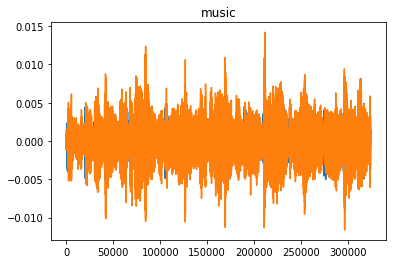

In [6]:
fs = 44100    #tanto las grabs como los originales tienen la misma frecuencia de sampleo
for sig in signals:
   signals[sig]['u'], signals[sig]['d'] = sinc_signals(signals[sig]['u'],signals[sig]['d'],signals[sig]['shift'],fs,sig)

###Calculamos r, p y la varianza de d (sigma2d)
r es el vector de los coeficientes de autocorrelación; p, el vector de correlación cruzada.

In [0]:
def estimate(u, d):
#esta funcion no devuelve la matriz de autocorrelación R porque es de tamaño len(u), y consumiría aprox más de 666 GB de memoria
  u_fft = np.fft.fft(u)
  d_fft = np.fft.fft(d)
  
  r = np.fft.ifft(u_fft * u_fft.conj()).real
  r = r[:len(u)//2]/len(u)

  p = np.fft.ifft(u_fft * d_fft.conj()).real
  p = p[len(u)//2:]/len(u)
  p = np.flip(p)

  sigma2d = np.var(d)
  return r, p, sigma2d

In [0]:
def calc_optimum_filter(R, p, sigma2d):
  '''
  Calcula el filtro Wiener óptimo
  
  sigma2: energía de la señal de entrada
  R: matriz de autocorrelación
  p: vector de correlación cruzada
  '''
  
  wo = np.dot(np.linalg.inv(R), p)
  Jmin = sigma2d - p.dot(wo)
  return (wo, Jmin)

In [0]:
#vector para órdenes del filtro
M = np.array([1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000,6000])

In [0]:
def get_filter(r, p, u, sigma2d):
    Jmin = np.zeros(len(M))
    for i in range(len(M)):
        print("Calculando filtro de orden", M[i])
        R = scipy.linalg.toeplitz(r[:M[i]])
        wo, Jmin[i] = calc_optimum_filter(R, p[0:M[i]], sigma2d)
    return wo, Jmin


Calculando para music
Calculando filtro de orden 1
Calculando filtro de orden 2
Calculando filtro de orden 3
Calculando filtro de orden 4
Calculando filtro de orden 5
Calculando filtro de orden 6
Calculando filtro de orden 7
Calculando filtro de orden 8
Calculando filtro de orden 9
Calculando filtro de orden 10
Calculando filtro de orden 20
Calculando filtro de orden 30
Calculando filtro de orden 40
Calculando filtro de orden 50
Calculando filtro de orden 60
Calculando filtro de orden 70
Calculando filtro de orden 80
Calculando filtro de orden 90
Calculando filtro de orden 100
Calculando filtro de orden 200
Calculando filtro de orden 300
Calculando filtro de orden 400
Calculando filtro de orden 500
Calculando filtro de orden 600
Calculando filtro de orden 700
Calculando filtro de orden 800
Calculando filtro de orden 900
Calculando filtro de orden 1000
Calculando filtro de orden 2000
Calculando filtro de orden 3000
Calculando filtro de orden 4000
Calculando filtro de orden 5000
Calculan

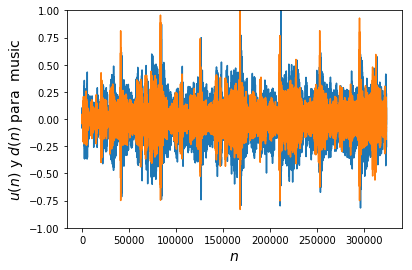

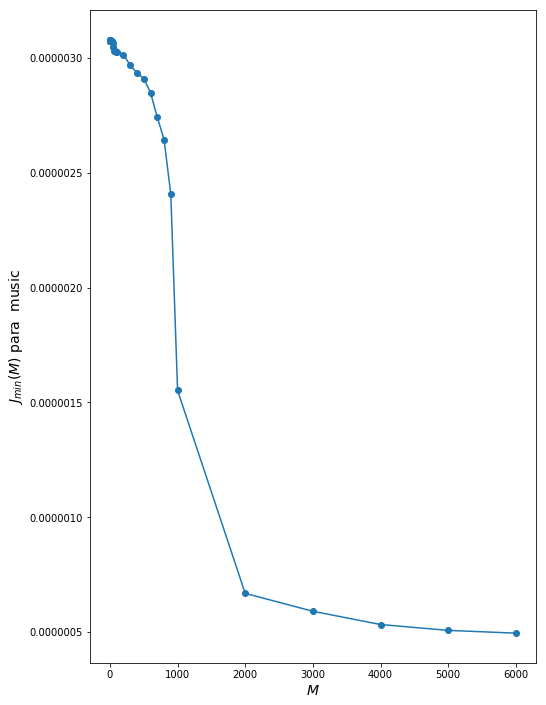

El valor de e es:  0.160688086828508


In [25]:
for sig in signals:
  print("Calculando para",sig)
  u = signals[sig]['u']
  d = signals[sig]['d']

  #calculo r, p, y sigma2d (la varianza)
  r,p,sigma2d = estimate(u, d)

  #Calculo el filtro para cada orden
  wo, Jmin = get_filter(r, p, u, sigma2d)

  ##Grafico la salida del filtro y la comparo con la deseada
  y = scipy.signal.filtfilt(wo,[1],u)
  d = d/max(d)
  y = y/max(y)
  plt.figure()
  plt.plot(d)
  plt.plot(y)
  plt.ylim(-1,1)
  plt.xlabel('$n$', fontsize=14)
  plt.ylabel('$u(n)$ y $d(n)$ para  ' + sig, fontsize=14)
  plt.show()

  ##Grafico de Jmin en función de M
  plt.figure(figsize=(8, 12))
  plt.plot(M,Jmin, marker='o')
  plt.xlabel('$M$', fontsize=14)
  plt.ylabel('$J_{min}(M)$ para  ' + sig, fontsize=14)
  plt.show()

  #Orden optimo
  Mopt = M[len(M)-1]
  ##Calculamos e para el M optimo
  e = Jmin[len(M)-1]/sigma2d
  print("El valor de e es: ", e)






In [26]:
# Escuchamos la salida del filtro
  Audio(y,rate=fs)